In [14]:
# Original file name: tis.ipynb from Rare Event Summer School in Dropbox
# New file name: TPS.ipynb
# Modified by PH Minh
# Last Updated Date: 03-17-2023 

## TPS Tutorial

- This code will perform transition path sampling (TPS) on a simple potential energy surface (PES). In this code, TPS will include 2 different shooting moves for users to explore, as well as 4 different PES. The visuals for different shooting moves and PES can be found below. 

- The code is constructed as follows: 

    - Choosing your PES

    - Deciding on your simulation settings

    - Generate an initial path at a higher temperature

    - Perform TPS on your selected PES at your desired temperature

    - Visualize successful and unsuccessful paths

    - Construct autocorrelation graphs for paths in the transition path ensemble (TPE)
    
    - Compare degree of path correlation between the usage of different shooting moves

## Learning Objectives

1. Understand what a transition path sampling (TPS) is.  

2. Explore the importance of different shooting moves.
    
    - How does your choice of shooting move impact your sampling/ path correlation?

    - How do you visualize or quantify how correlated paths are to one another?

3. Explore the importance of sampling on different potential energy surface (PES).
    * To do this exploration, you can modify the following variables in the code:

        - **pes_type**: this will change the PES that you use for your simulation 

        - **op_type**: this will change the form of your op. The options provided are op_type = x, y, or x+y

        - **basinA; basinB**: this will change where you define your basin(s) on the PES

        - **init_coords**: this will change where you start on your PES in your simulation

        - **beta**: this will change the temperature since beta = 1/(k_B*T), which consequently also changes the PES barrier height due to the change in temperature (T)

    * Questions to think about while exploring: 

        - How does changing variables related to the PES/my system (like pes_type, beta, basinA, basinB) impact my sampling?
        

## Energy surface contours options

PES-1: $$ V(x,y) = 0.02(x^4+y^4) - 4\exp(-(x+2)^2 - (y+2)^2) - 4\exp(-(x-2)^2 - (y-2)^2) + 0.3(x-y)^2 + 0.0026 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-1.png"> 

PES-2: $$ V(x,y) = 0.03(x^4+y^4) - 4\exp(-(x+2)^2 - (y+2)^2) - 4\exp(-(x-2)^2 - (y-2)^2) + 0.4(x-y)^2 + 4\exp(-(x^2+y^2)) - 2.1245 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-2.png">

PES-3: $$ V(x,y) = 0.02(x^4+y^4) - 3.73\exp(-\frac{(x+2)^2}{8} - \frac{(y+2)^2}{8}) - 3.73\exp(-\frac{(x-2)^2}{8} - \frac{(y-2)^2}{8}) + 3\exp(-\frac{x^2}{2} - \frac{y^2}{15}) + 2\exp(-\frac{x^2}{2} - \frac{y^2}{2}) - 0.5085 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-3.png">

PES-4: Müller-Brown Potential 
$$ V_{MB}(x,y) = \sum_{i=1}^{4}{A_{i}\exp([ a_{i}(x-\bar{x_{i}})^2 + b_{i}(x-\bar{x_{i}})(y-\bar{y_{i}}) + c_{i}(y-\bar{y_{i}})^2 ])} $$ 
where:

$$ A = [-200, -100, -170, 15] $$
$$ a = [-1, -1, -6.5, 0.7] $$
$$ b = [0, 0, 11, 0.6] $$
$$ c = [-10, -10, -6.5, 0.7] $$
$$ \bar{x} = [1, 0, -0.5, -1] $$
$$ \bar{y} = [0, 0.5, 1.5, 1] $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-4.png">

## Choose your PES

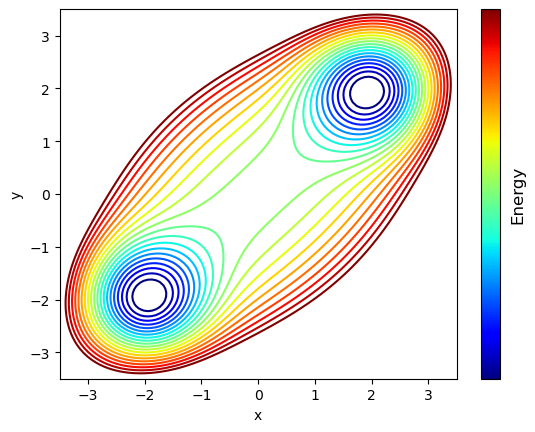

In [15]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm

# Select your PES type: ***** EDIT HERE *****
pes_type = 1

if pes_type == 4:
    # Plot potential energy surface contours
    N = 100
    x_vec = np.linspace(-3, 1.5, N)
    y_vec = np.linspace(-1, 3, N)
    X, Y = np.meshgrid(x_vec, y_vec)
    energy = np.zeros((N, N))
    
    # Plot contours
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show

else:
    # Plot potential energy surface contours
    N = 100
    x_vec = np.linspace(-3.5, 3.5, N)
    y_vec = np.linspace(-3.5, 3.5, N)
    X, Y = np.meshgrid(x_vec, y_vec)
    energy = np.zeros((N, N))

    # Plot contours
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show

## Simulation Settings

<function matplotlib.pyplot.show(close=None, block=None)>

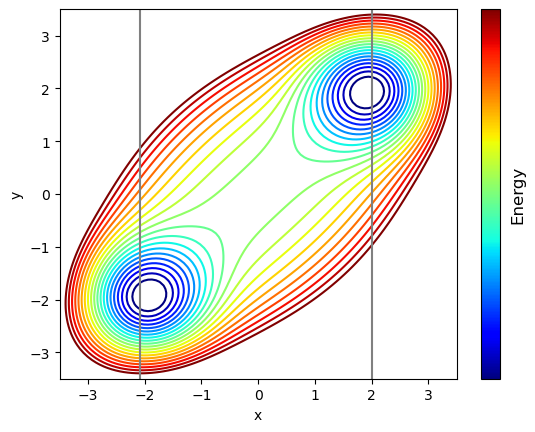

In [16]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

# TPS settings
n_moves = 1000              # number of moves to perform for each path ensemble - path ensemble corresponding to each diff interface
op_type = 1                 # order parameter;  1:x  2:y  3:x+y
basinA = -2.09              # boundary of basin A; must be less than the first interface
basinB = 2                  # basin B defined as last interface
init_coords = [-1, -1]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000           # basin equilibration length (steps)
basinlen = 50000            # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation
move_type = 1               # type of shooting move

#Langevin dynamics settings
beta = 2.5                  # 1/kT
gamma = 5.0                 # friction
dt = 0.01                   # time step size




# Plot PES with your selected basin

for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

if pes_type == 4:
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
else:   
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')
plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')

cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show

## Shooting Move Visuals

**Image of shooting moves implemented**

## Generate the initial paths by simulating at a higher temperature

- Why do we need to generate an initial path at a higher temperature? **Bonus**: How do we control the temperature? 

**[Answer: Edit Text]**

<function matplotlib.pyplot.show(close=None, block=None)>

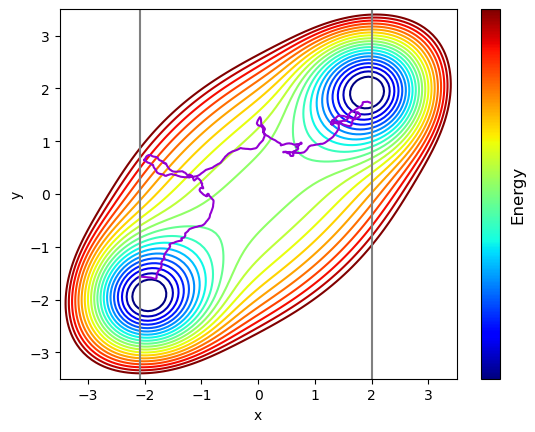

In [17]:
# Run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5                                                     # this controls the temperature because beta = 1/kb*T
fromBasin = False

# Calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type)

# Combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]

# Use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma,pes_type)  # array of x, y, px, py, fx, fy to get the first config to generate a path
op = ld.calc_op(op_type,trajstep[0],trajstep[1])                        # calculate the op to see where this config is at, in A or pass A and cross some lambda, or in B?

while op < basinB:                                                      # as long as it is not in B
    nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma,pes_type)              # generate next config
    trajstep = nextstep                                                 # save this config to trajstep, so we could shoot from it again 
    op = ld.calc_op(op_type,trajstep[0],trajstep[1])

    if op < basinA:                                                     # if this then this traj is from basin A 
        fromBasin = True
        initpath = []                                                   # reset path if it returns to A - do this until it's about to leave the basin
        trajstep = np.append(trajstep,[op],axis=0)                      # array of x, y, px, py, fx, fy and op value
        initpath.append(trajstep) 
        continue

    if op >= basinA and fromBasin == True:                              # now that you have left basin A, we'll save the different configs to the list initpath
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue

initpath = np.asarray(initpath)                                         # this gives all configurations of this 1 initial path

allpaths = []                                                           # list to keep track of the TPE
allpaths.append(initpath)                                               # append the initial path into this list to get our simulation started   


# Visualize the initial path 

if pes_type == 4:
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
else:   
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

plt.plot(allpaths[0][:,0],allpaths[0][:,1],color='darkviolet')   

plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')
plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')

cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show 


## Perform TPS

In [18]:
acc = 0
successful_paths = []
unsuccess_paths = []

for move in range(1, n_moves):
    print('Move =', move)

    # Perform shooting move
    # print('Performing Shoot Move')

    path = allpaths[move-1]                                                 # looks at the most current path of the TPE of interface i
    reject_move = False
    lmax = round((len(path) + 1)/np.random.uniform())                       # l max = maximum path length for flexible shooting 
    # print(lmax)

    # Pick random shooting point
    index = np.random.randint(len(path) - 2) + 1                            

    # Perturb the momenta
    shoot_point = copy.deepcopy(path[index])                                # gives me 1 phase space point/config along the path
    shoot_point[2] += np.random.normal(0,sigma)                             # px
    shoot_point[3] += np.random.normal(0,sigma)                             # py
    trial_path = np.asarray([shoot_point])                                  # new trial path after perturbing the momenta

    if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
        # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
        # before even shooting it
        reject_move = True
        # print('Shooting Move Rejected! Momenta pertubation unsuccessful!')

    # Integrate backwards path if we have not rejected the move...
    if reject_move == False:
        path_length = 1
        trial_path[:,2] *=-1                                                # change px to the negative direction by * -1
        trial_path[:,3] *=-1                                                # change py to the negative direction by * -1
        trajstep = copy.deepcopy(trial_path[-1])                            # take the last config of trial path
        op = ld.calc_op(op_type,trajstep[0],trajstep[1])                    # calc op value for config

        while op >= basinA:
            trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)      # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            trajstep = np.append(trajstep,[op],axis=0)
            trial_path = np.append(trial_path,[trajstep],axis=0)
            path_length +=1

            # Reject if the maximum path length is exceeded
            if path_length > lmax:
                reject_move = True
                # print('Shooting Move Rejected! Path length limit.')
                unsuccess_paths.append(trial_path)
                break

            # Reject if the backward path segment goes to B
            if op >= basinB:
                reject_move = True
                # print('Shooting Move Rejected! Backward path goes to B.')
                unsuccess_paths.append(trial_path)
                break

    # Forward shooting             
    if reject_move == False: 
        trial_path = np.flip(trial_path,axis=0)                              # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                             # so we flip so that the last config we extract from here will be where we'll use to shoot forward
        trial_path[:,2] *=-1
        trial_path[:,3] *=-1
        trajstep = copy.deepcopy(trial_path[-1])
        op = ld.calc_op(op_type,trajstep[0],trajstep[1])

        while op < basinB:                                                   # this is so that it restricts forward shooting to end in B

            nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
            trajstep = nextstep
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            trajstep = np.append(trajstep,[op],axis=0)
            trial_path = np.append(trial_path,[trajstep],axis=0)
            path_length +=1
            
            if path_length > lmax:
                reject_move = True
                # print('Shooting Move Rejected! Path Length Limit!')
                unsuccess_paths.append(trial_path)
                break
            
            if op <= basinA:
                reject_move = True
                # print('Shooting Move Rejected! Forward section reached A!')
                unsuccess_paths.append(trial_path)
                break
    
    # If we DON'T reject, then path becomes trial path
    if reject_move == False:
        # print('Shooting Move Accepted!')
        path = trial_path
        acc += 1
        successful_paths.append(path)                                      
    
    # Append current accepted path to its corresponding path ensemble
    allpaths.append(path)
                                                       
    # Calculate acceptance probability
    print('Acceptance Probability: {}'.format(acc/n_moves))

Move = 1
Acceptance Probability: 0.0
Move = 2
Acceptance Probability: 0.0
Move = 3
Acceptance Probability: 0.0
Move = 4
Acceptance Probability: 0.0
Move = 5
Acceptance Probability: 0.0
Move = 6
Acceptance Probability: 0.0
Move = 7
Acceptance Probability: 0.0
Move = 8
Acceptance Probability: 0.0
Move = 9
Acceptance Probability: 0.0
Move = 10
Acceptance Probability: 0.0
Move = 11
Acceptance Probability: 0.0
Move = 12
Acceptance Probability: 0.0
Move = 13
Acceptance Probability: 0.0
Move = 14
Acceptance Probability: 0.0
Move = 15
Acceptance Probability: 0.0
Move = 16
Acceptance Probability: 0.0
Move = 17
Acceptance Probability: 0.0
Move = 18
Acceptance Probability: 0.0
Move = 19
Acceptance Probability: 0.0
Move = 20
Acceptance Probability: 0.0
Move = 21
Acceptance Probability: 0.0
Move = 22
Acceptance Probability: 0.0
Move = 23
Acceptance Probability: 0.0
Move = 24
Acceptance Probability: 0.0
Move = 25
Acceptance Probability: 0.0
Move = 26
Acceptance Probability: 0.0
Move = 27
Acceptance 

## Plot the successful paths from the transition path ensemble (TPE)

- How many successful paths are there? 

In [19]:
## EDIT HERE YOUR CODE HERE ##


## Answer Key

In [20]:
# skip = 10

# for j in range(0,len(successful_paths),skip):
#     plt.plot(successful_paths[j][:,0],successful_paths[j][:,1],color='darkviolet')

    # if pes_type == 4:
    #     plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    # else:   
    #     plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')    

#     plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')
#     plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')

#     cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
#     cbar.set_ticks([])
#     cbar.set_label(label = 'Energy', size=12)
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.show()


## Plot unsuccessful paths 

-   What are the criteria for a path to be rejected from the TPE?

-   What do you expect these rejected paths to look like?

In [21]:
## EDIT HERE YOUR CODE HERE ##


## Answer Key

In [22]:
# # Plot
# skip = 50

# for j in range(0,len(unsuccess_paths),skip):
#     plt.plot(unsuccess_paths[j][:,0],unsuccess_paths[j][:,1],color='darkviolet')

    # if pes_type == 4:
    #     plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    # else:   
    #     plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
    
#     plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')
#     plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='grey')


#     cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
#     cbar.set_ticks([])
#     cbar.set_label(label = 'Energy', size=12)
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.show()

## Check the path correlation

- Why does path correlation matter?

- Can you think of other properties that you can also use to determine how correlated paths are in the TPE?

**[Answer: Edit Text]**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


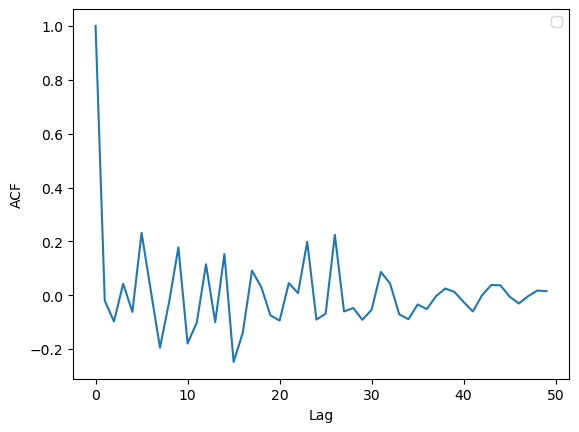

In [23]:
""" Autocorrelation Graph: Criteria = Pathlength """
""" The equation used for ACF calculation is:   [INSERT]           """

maxlag = 50                                                 # Define your max lag
acf_p = [] 

pathlengthsvals = []                                        # List to store pathlength values of each path of an interface ensemble

start = 0                                                   # You define what move the ACF starts at, this should correspond to where the 
                                                            # running average crossing prob. converges

# Gather information about each move for an interface ensemble
for move in range(start,len(successful_paths)):                   
    pathlengthsvals.append(len(successful_paths[move]))

# Calculate ACF 
# Get mean 
pl = np.asarray(pathlengthsvals)

plavg = np.mean(pl)

# Get denominator
denom_pl = np.sum((pl-plavg)**2)

# Get numerator 
for lag in range(maxlag):
    sample = len(pl) - lag                                    # Number of samples that we're going to calculate ACF over
    
    acfpl = 0

    for j in range(sample):
        numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)

        # Get ACF values
        acfpl += numer_pl/denom_pl

    acf_p.append(acfpl)

# Plot ACF Graphs 

plt.plot(range(0,lag+1),acf_p)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.show()


## How would you change this ACF code so that you could graph the difference in ACF when you use different shooting moves?

In [24]:
## EDIT YOUR CODE HERE ##

## Answer Key

In [25]:
# """ Autocorrelation Graph: Criteria = Pathlength """
# """ The equation used for ACF calculation is:   [INSERT]           """

# maxlag = 50                                                 # Define your max lag
# acf_p = [] 

# pathlengthsvals = []                                        # List to store pathlength values of each path of an interface ensemble

# start = 0                                                   # You define what move the ACF starts at, this should correspond to where the 
#                                                             # running average crossing prob. converges

# # Gather information about each move for an interface ensemble
# for move in range(start,len(successful_paths)):                   
#     pathlengthsvals.append(len(successful_paths[move]))

# # Calculate ACF 
# # Get mean 
# pl = np.asarray(pathlengthsvals)

# plavg = np.mean(pl)

# # Get denominator
# denom_pl = np.sum((pl-plavg)**2)

# # Get numerator 
# for lag in range(maxlag):
#     sample = len(pl) - lag                                    # Number of samples that we're going to calculate ACF over
    
#     acfpl = 0

#     for j in range(sample):
#         numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)

#         # Get ACF values
#         acfpl += numer_pl/denom_pl

#     acf_p.append(acfpl)

# # Plot ACF Graphs 

# plt.plot(range(0,lag+1),acf_p)
# plt.xlabel('Lag')
# plt.ylabel('ACF')
# plt.legend()
# plt.show()
